            deaths
years             
1969-01-01     141
1970-01-01     150
1971-01-01     151
1972-01-01     145
1973-01-01     155
(0.9135986749292919, True)
50
35 15
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=332.223, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=318.570, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=312.984, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=313.312, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0

-5.278638795437769

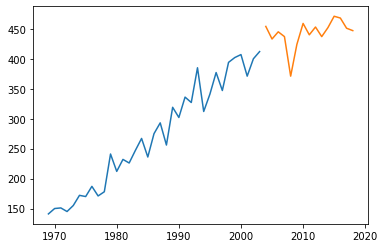

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

from pmdarima.arima import ADFTest


filename= 'data/mortalityLung'
#filename= 'data/crudeAge75to79'
#filename= 'data/crudeAge80to84'
#filename= 'data/crudeAge85'

#filename= 'data/crudeCountyDavis'
#filename= 'data/crudeCountySaltLake'
#filename= 'data/crudeCountyUtah'
#filename= 'data/crudeCountyWeber'
#filename= 'data/crudeCountyWashington'

#filename= 'data/mortalityMale'
#filename= 'data/mortalityFemale'


deaths_data = pd.read_csv(filename+".csv",
                       index_col ='years',
                       parse_dates = True)


print(deaths_data.head())


#Make sure there are no null values at the end of the dataset
deaths_data.tail()

deaths_data.dtypes

deaths_data.head()

#sales_data.plot()

adf_test = ADFTest(alpha = 0.05)
print(adf_test.should_diff(deaths_data))


print(len(deaths_data))

start = int(len(deaths_data) * 0.7)

end = len(deaths_data) - start + 1

train = deaths_data[:start]
test = deaths_data[start:]
print(len(train), len(test))
train.tail()

test.head()

plt.plot(train)
plt.plot(test)
arima_model =  auto_arima(train, start_p=0, start_d=0, start_q=0, 
                          max_p=5, max_d=3, max_q=3, start_P=0, 
                          D=0, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, seasonal=False, 
                          error_action='warn',trace = True,stepwise = False)

#print(arima_model.summary())

prediction = pd.DataFrame(arima_model.predict(n_periods =end - 1),index=test.index)
prediction.columns = ['predicted_deaths']
prediction


order = arima_model.get_params()["order"]
ar, i, ma = order
print("Parameters", order)
print(ar, i, ma)
#print(prediction)

'''
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()
'''


from sklearn.metrics import r2_score
test['predicted_deaths'] = prediction
print(prediction)
r2_score(test['deaths'], test['predicted_deaths'])


                             ARIMA Model Results                              
Dep. Variable:               D.deaths   No. Observations:                   49
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -223.939
Method:                       css-mle   S.D. of innovations             23.142
Date:                Sun, 30 Oct 2022   AIC                            461.878
Time:                        22:40:58   BIC                            475.120
Sample:                    01-01-1970   HQIC                           466.902
                         - 01-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.7343      0.993      6.778      0.000       4.787       8.681
ar.L1.D.deaths    -0.3700      0.288     -1.286      0.198      -0.934       0.194
ar.L2.D.deaths    -0.2810      0.241

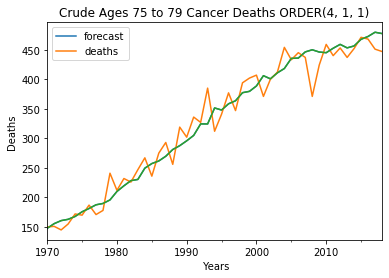

In [5]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

train=deaths_data.iloc[:]
if i < 1:
    i = 1
    model2 = ARIMA(train["deaths"], order=(ar,i, ma))
    print(i)
else:
    model2 = ARIMA(train["deaths"], order=(ar, i, ma))
model2 = model2.fit()
print(model2.summary())


myax = model2.plot_predict(start=1, end=len(deaths_data)-1)



model2 = model2.predict(start=1, end=len(deaths_data)-1, typ="levels")
#print(model2)
#model2.to_csv("ages75_arima.csv")
ax = model2.plot()
ax.set_title("Crude Ages 75 to 79 Cancer Deaths ORDER(" + str(ar) + ", " + str(i) + ", " + str(ma) + ")")
ax.set_xlabel(" Years")
ax.set_ylabel("Deaths")
fig = ax.get_figure()
#fig.savefig('arima_plots/')

#print("len", deaths_data[0], "len", model2[0])
print("training score", math.sqrt(mean_squared_error(deaths_data[:start], model2[:start])))
print("testing score", math.sqrt(mean_squared_error(deaths_data[start:-1], model2[start:])))


f= open(filename+".txt", "w")
for i in range(len(model2.iloc[:])):
    f.write(str(model2.iloc[i]))
    f.write("\n")
f.close()
